# Setup

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import helpers_05

%matplotlib inline

# Convolutions

In order to give our model more spatial awareness, provide translation invariance, and reduce the amount of parameters in our network, we need to share weights in such a way that the same pixels located in different parts of a image output identical activation values. The technique we end up using is called a _convolution_.

![](images/convolution_animated.gif)

The defining feature of a convolution is the _kernel_ (also known as a _filter_), which is a grid-like set of weights which slides over regions of an input image. At each step, the kernel weights are multiplied with the corresponding pixel values underneath. These multiplied values are then summed to get the output value at that point.

![](images/convolution_still.png)

By performing the operation in this way, we can use local spatial information while also making sure that each part of the image can be examined with the same weights.

This is something that is easier to learn visually, so let's take a look at a simple example:

![](images/basic_kernel_anim.gif)

Here, we have a 5x5 input matrix, and our kernel is 3x3. When the kernel is placed in the top-left portion of the input, we end up with the following total sum:

```
(1 * -1) + (2 * 1) + (0 * 2) + (1 * 1) + (0 * 1) + (0 * 0) + (2 * -1)+ (2 * 0) = -2
```

We can see that the value of `-2` is the top-left entry in our output matrix. As we slide the kernel across the image, we get corresponding outputs which follow the kernel spatially. 

## Manual Convolutions with NumPy

Let's do a quick example in NumPy/TensorFlow to verify that the above illustration works. First, we'll create our input matrix and kernels in NumPy:

In [2]:
# Example input matrix
a = np.array([[1, 2, 0, 3, 1],
              [1, 0, 0, 2, 2],
              [2, 1, 2, 1, 1],
              [0, 0, 1, 0, 0],
              [1, 2, 1, 1, 1]]).reshape(1,5,5,1).astype(np.float32)

# Example kernel
kernel = np.array([[-1,  1, 2],
                   [ 1,  1, 0],
                   [-1, -2, 0]]).reshape(3,3,1,1).astype(np.float32)

You can see that the values we set in our NumPy arrays match those in the visual above. A small implementation quirk is that we reshape the NumPy arrays.  The input matrix goes from `[5, 5]` to `[1, 5, 5, 1]`. The values, from left to right, represent the number of elements:
  * in the batch (1), 
  * the height (5), 
  * the width (5), and 
  * the number of channels (1). 
  
If our test matrix represented an RGB image, the shape would be `[1, 5, 5, 3]`. If there were 10 images in the batch, the shape would be `[10, 5, 5, 1]`

The kernel goes from `[3, 3]` to `[3, 3, 1, 1]`. The values, from left to right, represent:
  * the height of the kernel (3), 
  * the width of the kernel (3), 
  *  the number of channels in the _input_ (1), and 
  *  the number of channels in the output (1). 
  
If the input represented an RGB image, we'd have the shape `[3, 3, 3, 1]`, and if we wanted our output to have 5 channels, the output shape would be `[3, 3, 1, 5]`.  Think of the last two components as being similar to a weight matrix on a fully connected layer, which has the shape `[prev_num_neurons, curr_num_neurons]`.
    
Now that we have our dummy data, let's run it and see what we get!  

In [3]:
out = tf.Session().run(tf.nn.conv2d(input=a,
                                    filter=kernel,
                                    strides=[1, 1, 1, 1],
                                    padding='VALID'))
# np.squeeze() removes dimensions equal to `1` from a matrix/tensor
# The result of tf.conv2d is four dimensional, so this cleans it up
print(out.squeeze())

[[-2. -1.  3.]
 [ 2.  5.  8.]
 [-2.  0. -1.]]


The `tf.nn.conv2d()` Operation expects four main arguments: `input`, `filter`, `strides`, and `padding`:

* `input` is the input Tensor, in this case our `[1, 5, 5, 1]` test data.
* `filter` is the kernel. Typically, this would be a `tf.Variable`, but in this demo it's just our `[3,3,1,1]` kernel.

The other two inputs are things we haven't talked about yet, stride and padding.

##### Stride

"Stride" refers to the number of squares we move our kernel for each step (both vertically and horizontally). In the above example, both our strides (horizontal and vertical) were 1, but if they were set to 2, the operation would look like this:

![](images/basic_kernel_stride2_anim.gif)

One note:  we "walk" across using the horizontal stride (across columns) before we "reset" back to the left with the vertical stride (down rows).  This is almost like an old-school typewriter with a *ding* when you get to the end of the line.

Because we're skipping over a square in both directions, our output `Tensor` is 2x2 instead of 3x3. This is one way to reduce the spatial dimensions of a network- we'll look at another technique for this, pooling, later in this lesson.

The way we set the stride in TensorFlow is with the `stride` parameter, which is a list of integers with the form `[1, vert_stride, hori_stride, 1]` (the first and last elements have to be `1`. We can test this out by modifying the code from above:

In [4]:
out = tf.Session().run(tf.nn.conv2d(input=a,
                                    filter=kernel,
                                    strides=[1, 2, 2, 1],
                                    padding='VALID'))
print(out.squeeze())

[[-2.  3.]
 [-2. -1.]]


##### Padding

You may have noticed that we ended up reducing the spatial dimensions from our input to the output: we start with a `5x5` Tensor, and end up with a `3x3` Tensor as output. While this is sometimes ok, it's often the case that we want to maintain the width and height of out input. We can achieve this by adding zeros around our image or *padding* the image. By adding a ring of one or more zeros to the outside of our input and letting our kernel "overflow" on the sides, we can ensure that the output dimensions match the input dimensions.

![](images/padded_kernel_anim.gif)

_Side note: the amount of zeros needed on the outside of the input depends on the size of the kernel: `3x3` needs one layer of zeros, `5x5` needs two, `7x7` needs three, etc._

We can control padding in TensorFlow by using the `padding` parameter. `padding` takes a string which selects between two options:

* `'VALID'` is what we used above - no zero padding. The idea is that we're only using "real" or "valid" input data to get outputs. You could also think of it as the kernel not going "out of bounds", thus staying "valid"
* `'SAME'` uses zero-padding to keep the output dimensions equal to that of the input (assuming horizontal and vertical stride is set to 1). This one is more self-explanatory: we're keeping the dimensions the "same"

_Side note: this naming scheme comes from the convolution syntax in [NumPy](https://docs.scipy.org/doc/numpy/reference/generated/numpy.convolve.html) and [MATLAB](https://www.mathworks.com/help/matlab/ref/conv2.html)_

Let's try out `'SAME'` padding with our dummy data:

In [5]:
out = tf.Session().run(tf.nn.conv2d(input=a,
                                    filter=kernel,
                                    strides=[1, 1, 1, 1],
                                    padding='SAME'))
print(out.squeeze())

[[-1.  2.  2. -1. -2.]
 [ 2. -2. -1.  3. -1.]
 [ 3.  2.  5.  8.  2.]
 [ 2. -2.  0. -1. -3.]
 [ 1.  5.  4.  1.  2.]]


## Multiple layers of input and kernels

![](images/two_layer_kernel_anim.gif)

![](images/two_layer_kernel_final.png)

##### Adding a Bias

We will also add in a bias term for convolutions the same way we would a fully-connected layer. Each layer of the filter will have a constant number that is added along with the rest of the kernel dot product. We create a `Variable` vector with the same depth as the output `Tensor` (the last number in the shape of the kernel). Then, we use [`tf.nn.bias_add()`](https://www.tensorflow.org/versions/master/api_docs/python/nn/activation_functions_#bias_add) to add the value the output of our convolution.

```
conv = tf.nn.conv2d(input, kernel, ...)
bias = tf.Variable(tf.constant(0.1, shape=[depth]))
total = tf.nn.bias(conv, bias)
```

For convolutions, the bias is usually initialized to some small positive value (as opposed to zero). We do this because the general go-to activation function for CNNs is ReLU, which can "die" if they never get positive inputs.

##### Small Aside About Kernels

[Kernels](https://en.wikipedia.org/wiki/Kernel_(image_processing) have been used in image processing for many years for tasks such as edge detection, blurring, and sharpening. The basic idea of convolutional neural networks is that we can let the computer find useful kernels for the task instead of using handmade, pre-defined ones.

# Pooling

Earlier, we saw that using a higher stride convolution results in collapsing the spatial dimensions of our network. While it is sometimes advantageous to do this during trained convolutions, a more common technique is to use _pooling_, which does a transformation on neighboring inputs (but is not trained/has zero parameters).

## Max Pooling

In max pooling, the network looks at a chunk of neighboring pixels and outputs the largest pixel from that group:

![Max pooling, size 2, stride 2](images/maxpool.png)

In this example, we've split a `4x4` matrix into four groups (shown by  colors), each holding four numbers. We take the largest number from each group to output the matrix on the right. To demonstrate this in TensorFlow, we'll use the [`tf.nn.max_pool()`](https://www.tensorflow.org/versions/master/api_docs/python/nn/pooling#max_pool) Op. Because each group is a `[2x2]` box, and there are 2 steps between boxes (horizontally and vertically), we say that this is a max pool, size 2, stride 2.

In [6]:
# Setup our input array
pool_me = np.array([[ 2,  1,  0, -1],
                    [-3,  8,  2,  5],
                    [ 1, -1,  3,  4],
                    [ 0,  1,  1, -2]]).reshape(1,4,4,1).astype(np.float32)

out = tf.Session().run(tf.nn.max_pool(value=pool_me,
                                      ksize=[1, 2, 2, 1],
                                      strides=[1, 2, 2, 1],
                                      padding='VALID'))
print(out.squeeze())

[[ 8.  5.]
 [ 1.  4.]]


You'll notice that max pooling has similar parameters to `tf.nn.conv2d()`. The primary difference is `ksize` instead of `filter`: `ksize` is a list of integers representing the shape of the pooling kernel with shape `[1, k_height, k_width, 1]`. In this case, it's `[1, 2, 2, 1]`, as our kernel is two squares high and two squares wide.

`stride` and `padding` act the same as they do for convolutions. In general the `strides` option is the same or larger as `ksize` (no overlapping kernels), and `padding` is generally set to `'VALID'`.

## Average Pooling

Average pooling is the same idea as max pooling, only instead we take the average of all the values in each group.

![Average pooling, size 2, stride 2](images/avgpool.png)

We can use average pooling with the [`tf.nn.avg_pool`](https://www.tensorflow.org/versions/master/api_docs/python/nn/pooling#avg_pool) Op:

In [7]:
out = tf.Session().run(tf.nn.avg_pool(value=pool_me,
                                      ksize=[1, 2, 2, 1],
                                      strides=[1, 2, 2, 1],
                                      padding='VALID'))
print(out.squeeze())

[[ 2.    1.5 ]
 [ 0.25  1.5 ]]


## Max or Avg Pool?

The jury is still out as to whether or not there is a definitive answer whether max pooling or average pooling is more effective. At this time, I'd say max pooling is more common, though average pooling is used in several well-regarded modern models.

You can read a thorough discussion in [_A Theoretical Analysis of Feature Pooling in Visual Recognition_ (Boureau et al)](http://people.ee.duke.edu/~lcarin/icml2010b.pdf) if you want to dive deeper into the debate!

# LeNet

[FIXME: Add text.]  Our goal now is to implement LeNet.  

In [8]:
# we're going to make use a few names that we defined last week
# they've been gathered in helpers_05.py
from helpers_05 import (batches, flatten, fully_connected_layer,
                        fully_connected_sigmoid_layer,
                        test_and_show_images)

## Convolution Layers

[FIXME:  add text]

In [9]:
def conv_layer(incoming, num_kernels, kernel_sz, 
               strides=[1, 1, 1, 1], padding='SAME',
               bval=0.01, 
               activation_fn=tf.nn.relu, 
               name=None):
    prev_outshape = incoming.shape.dims[-1].value
    kshape = kernel_sz + [prev_outshape, num_kernels]

    fan_in = np.prod(incoming.shape[1:]).value
    xavier_stddev = np.sqrt(2.0 / fan_in)
    
    with tf.variable_scope(name, 'conv_layer'):
        w = tf.Variable(tf.truncated_normal(kshape, stddev=xavier_stddev), name='kernel')
        b = tf.Variable(tf.constant(bval, shape=[num_kernels]), name='bias')
        conv = tf.nn.conv2d(incoming, w, strides, padding, name='conv')
        z = tf.nn.bias_add(conv, b)
        return z if activation_fn is None else activation_fn(z)

In [10]:
def pool_layer(incoming, ksize, strides=None, padding='VALID',
               pool_fn=tf.nn.max_pool, name=None):
    'create a pooling layer:  we auto-add the leading/trailing 1s'
    ksize = [1] + ksize + [1]
    # default strides to ksize
    strides = strides if strides is not None else ksize
    with tf.variable_scope(name, 'pool_layer'):
        return pool_fn(incoming, ksize, strides, padding)

## LeNet Sub-Networks

To get us warmed up, here is a simple network that shares some of the architecture of LeNet, but it is smaller and it uses sigmoid activations.

In [11]:
def not_lenet(images):
    with tf.name_scope('small_model'):
        conv_1 = conv_layer(images, 6, [5, 5])
        pool_1 = pool_layer(conv_1, [2, 2])
        conv_2 = conv_layer(pool_1, 16, [5, 5])
        pool_2 = pool_layer(conv_2, [2, 2])
        
        flat = flatten(pool_2)
        
        fc_layer = fully_connected_sigmoid_layer
        fc_1 = fc_layer(flat, 120)
        fc_2 = fc_layer(fc_1,  84)
        fc_3 = fully_connected_layer(fc_2,  10, w_stddev = 0.5, activation_fn=None)
    
    return fc_3 

We very briefly discussed Xavier initialization in the slides.  It isn't that hard to implement, either.  Here, we simply add a value to compute `w_stddev` instead of setting it to a fixed constant (see line 8 in the next cell).

In [12]:
def fully_connected_xavier_relu_layer(incoming_layer, num_nodes,
                                      b_val=0.01,
                                      keep_prob=None, name=None):
    ' pass through for fully_connected_layer with xavier init '
    incoming_layer = tf.convert_to_tensor(incoming_layer)
    prev_num_nodes = incoming_layer.shape.dims[-1].value
    
    w_stddev = np.sqrt(2.0 / prev_num_nodes)

    return fully_connected_layer(incoming_layer, num_nodes,
                                 w_stddev = w_stddev, b_val=b_val,
                                 activation_fn = tf.nn.relu,
                                 keep_prob=keep_prob,
                                 name=name)


With the above as a starting point, we can now recrete that actual LeNet.  Here's the table from the slides:

![](images/lenet-table.png)

and the graphic from the paper:

![](images/lenet.png)

Unfortunately, you have to combine information from the table and the graphic to get the numbers below.  The depths come from the graphic (they precede the `@` signs on the top of the figure).  The other values come from the table.

In [13]:
def lenet_small(images):
    with tf.name_scope('small_lenet_model'):    
        conv_1 = conv_layer(images, 6, [5, 5])
        pool_1 = pool_layer(conv_1, [2, 2])
        conv_2 = conv_layer(pool_1, 16, [5, 5])
        pool_2 = pool_layer(conv_2, [2, 2])

        flat = flatten(pool_2)

        fc_layer = fully_connected_xavier_relu_layer
        fc_1   = fc_layer(flat, 120)
        fc_2   = fc_layer(fc_1, 84)
        fc_3   = fc_layer(fc_2, 10)
        fc_4   = fully_connected_layer(fc_3, 10, activation_fn=None)
    
    return fc_4

And here's a scaled up LeNet:

In [14]:
def lenet_big(images):
    with tf.name_scope('big_lenet_model'):    
        conv_1 = conv_layer(images, 32, [5, 5])
        pool_1 = pool_layer(conv_1, [2, 2])
        conv_2 = conv_layer(pool_1, 64, [5, 5])
        pool_2 = pool_layer(conv_2, [2, 2])

        flat = flatten(pool_2)

        fc_layer = fully_connected_xavier_relu_layer
        fc_1   = fc_layer(flat, 400)
        fc_2   = fc_layer(fc_1, 200)
        fc_3   = fc_layer(fc_2, 200)
        fc_4   = fully_connected_layer(fc_3, 10, activation_fn=None)
    
    return fc_4

# Exercise

You mission, should you choose to accept it, is to take the pieces we've developed and turn them into a working model for Lenet on MNIST.  Here's a process to get you started:

  1. Grab either your CIFAR or MNIST model from last week.
  2.  Modify it so that your s.out is coming from one of the LeNet versions we defined above.
  3.  Modify your `training` block so it uses a slightly different optimizer (we will talk about these in the coming weeks).
```
    with tf.name_scope('train'):
        decayed_rate = tf.train.exponential_decay(s.learning_rate, global_step,
                                              600, 0.998, True)
        momopt = tf.train.MomentumOptimizer
        s.train = momopt(decayed_rate, 0.9).minimize(s.loss)
```
  4.  Read in your training and testing data with `helpers_05.get_mnist_dataset` (like we did last week)
  5.  Setup a training loop like we did last week.  Note, use a `learning_rate=0.001` and we don't need a `momentum` (which we used last time).
  6.  If things are working right, you shouldn't need 15 epochs of training.  Five or six should do.
  7.  Good luck!  Feel free to consult the solution below.

## Solution

In [15]:
class MNIST_Conv_Model(object):
    def __init__(s, lenet_function):  # non-standard, for abbreviation
        graph = tf.Graph()
        with graph.as_default():
            with tf.name_scope('inputs'):
                s.images = tf.placeholder(tf.float32, shape=[None, 28, 28, 1], name="x")
                s.labels = tf.placeholder(tf.int32, shape=[None])

            with tf.name_scope('hyperparams'):
                s.learning_rate = tf.placeholder(tf.float32, name='learning_rate')                
            
            # HUMMMMM:  why floating for one-hot?
            s.one_hot_labels = tf.one_hot(s.labels, 10, dtype=tf.float32) 
            
            # main LeNet component
            # this is setup so the user passes in one of the lenet functions defined above
            # (note, they pass in the function -not- the results of calling that function;
            #  we take care of calling it here)
            s.logits = lenet_function(s.images)
            
            with tf.name_scope('loss'):
                smce = tf.nn.softmax_cross_entropy_with_logits
                s.loss = tf.reduce_mean(smce(logits=s.logits, labels=s.one_hot_labels),
                                             name="loss")

            with tf.name_scope('global_step'):
                global_step = tf.Variable(0, trainable=False, name='global_step')
                s.inc_step = tf.assign_add(global_step, 1, name='inc_step')

            with tf.name_scope('train'):
                decayed_rate = tf.train.exponential_decay(s.learning_rate, global_step,
                                                          600, 0.998, True)
                momopt = tf.train.MomentumOptimizer
                s.train = momopt(decayed_rate, 0.9).minimize(s.loss)
            
            with tf.name_scope('prediction'):
                s.softmax    = tf.nn.softmax(s.logits, name="softmax")
                s.prediction = tf.cast(tf.arg_max(s.softmax, 1), tf.int32)
                
                s.pred_correct  = tf.equal(s.labels, s.prediction)
                s.pred_accuracy = tf.reduce_mean(tf.cast(s.pred_correct, tf.float32))    
            s.init = tf.global_variables_initializer()
            
        s.session = tf.Session(graph=graph)
        s.session.run(s.init)
    
    def fit(s, train_dict):
        tr_loss, step, tr_acc, _ = s.session.run([s.loss, s.inc_step, s.pred_accuracy, 
                                                  s.train], 
                                              feed_dict=train_dict)
        return tr_loss, step, tr_acc
    
    def predict(s, test_dict):
        ct_correct, preds = s.session.run([s.pred_correct, s.prediction], 
                                          feed_dict=test_dict)
        return ct_correct, preds

In [16]:
(train_data, train_labels, 
 test_data, test_labels) = helpers_05.get_mnist_dataset()

In [17]:
# took about 13 minutes to train not_lenet (epoch 6 got to 80%)
# took 30 minutes to train lenet_big (for 7 epochs)
#      got 1.0 training acc at epoch 1; 7 epochs gave 98% test accuracy
import time
start = time.time()

mm = MNIST_Conv_Model(lenet_full) # or lenet_full or not_lenet
for epoch in range(7):
    for batch_data, batch_labels in batches(train_data, train_labels, 100):
        train_dict = {mm.images : batch_data, 
                      mm.labels : batch_labels, 
                      mm.learning_rate : 0.001} # , # 1e-3
        tr_loss, step, tr_acc = mm.fit(train_dict)
    info_update = "Epoch: {:2d} Step: {:5d} Loss: {:8.2f} Acc: {:5.2f}"
    print(info_update.format(epoch, step, tr_loss, tr_acc))

end = time.time()
print("took", (end - start)/60.0, "minutes")

Epoch:  0 Step:   600 Loss:     0.23 Acc:  0.95
Epoch:  1 Step:  1200 Loss:     0.01 Acc:  1.00
Epoch:  2 Step:  1800 Loss:     0.02 Acc:  1.00
Epoch:  3 Step:  2400 Loss:     0.01 Acc:  1.00
Epoch:  4 Step:  3000 Loss:     0.00 Acc:  1.00
Epoch:  5 Step:  3600 Loss:     0.01 Acc:  0.99
Epoch:  6 Step:  4200 Loss:     0.04 Acc:  0.99
took 1650.5897312164307


In [22]:
# Get test accuracy
batch_correct_cts = []
for batch_data, batch_labels in batches(test_data, test_labels, 200):
    test_dict = {mm.images : batch_data, 
                 mm.labels : batch_labels}
    correctness, curr_preds = mm.predict(test_dict)
    batch_correct_cts.append(correctness.sum())

print(sum(batch_correct_cts) / len(test_data))

0.9884


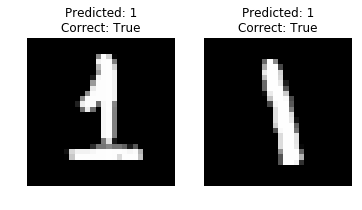

In [19]:
indices = [25, 125]
test_dict = {mm.images : test_data[indices],
             mm.labels : test_labels[indices]}
test_and_show_images(mm, test_dict, 
                     test_data[indices], test_labels[indices])

In [20]:
# Get correct images
correctness = []
for batch_data, batch_labels in batches(test_data, test_labels, 200):
    test_dict = {mm.images : batch_data,
                 mm.labels : batch_labels}
    curr_correctness, curr_preds = mm.predict(test_dict)
    correctness.extend(curr_correctness)
incorrect = np.where(np.logical_not(np.array(correctness, dtype=np.bool)))[0]

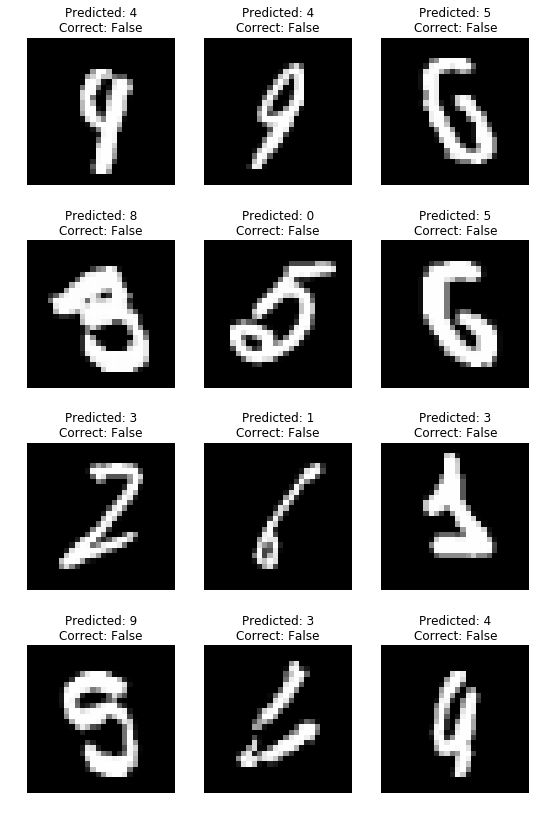

In [21]:
indices = incorrect[:12]
test_dict = {mm.images : test_data[indices],
             mm.labels : test_labels[indices]}
test_and_show_images(mm, test_dict,
                     test_data[indices], test_labels[indices])

# Optional Task

Now that we've got a more powerful network architecture, let's try to do better on CIFAR.  Take your new and improved LeNet model and point it at the CIFAR dataset.